# 0) Modules & Functions

In [1]:
import os
import pandas as pd
from rdkit import Chem
import subprocess
import hashlib
import tempfile
import base64
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from tqdm import tqdm
import time
from collections import defaultdict
from rdkit.Chem import AllChem
from rdkit import RDLogger
import warnings
import re
from rdkit.Chem import inchi
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from rdkit.Chem import Descriptors
from rdkit import Chem
from rdkit.Chem import Draw

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

warnings.filterwarnings("ignore", category=UserWarning, module="rdkit")
warnings.filterwarnings("ignore", category=FutureWarning, module="rdkit")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="rdkit")


from itertools import combinations
from pathlib import Path


import os
import pandas as pd
from pathlib import Path


import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, matthews_corrcoef,
    balanced_accuracy_score, f1_score, roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# === Fingerprint computation ===
def smiles_to_morgan(smiles, radius=3, n_bits=4096):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))

def parallel_fingerprint(smiles_list, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(smiles_to_morgan)(s) for s in smiles_list)


# 1) Prepare the data

In [2]:
set_augmentation = "AC"

full_MTL = pd.read_parquet(f"../data/aug/{set_augmentation}/MTL/MTL_merged.parquet")
full_MTL.AUG.value_counts()

AUG
True     12926
False     9645
Name: count, dtype: int64

In [3]:
full_MTL

,InChIKey,SMILES,AUG,oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN),oneADMET_LR-STL---pK$_{i}$ CXCR3 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ AMPN (HUMAN),oneADMET_LR-STL---pIC$_{50}$ ANM6 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ MP2K1 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ CAH12 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ SC6A2 (HUMAN),...,oneADMET_LR-STL---pIC$_{50}$ CRTN (STAAE),oneADMET_LR-STL---pK$_{i}$ DRD1 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ DGLA (HUMAN),oneADMET_LR-STL---pK$_{d}$ SC6A3 (HUMAN),oneADMET_LR-STL---pK$_{i}$ HGFA (HUMAN),oneADMET_LR-STL---pIC$_{50}$ CCR6 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ KPCA (HUMAN),oneADMET_LR-STL---pIC$_{50}$ ACHA3 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ EDNRB (PIG),oneADMET_LR-STL---pK$_{i}$ CAH2 (HUMAN)
0,AAARPHXZKXDSID-UHFFFAOYSA-N,CCc1nc2c(-c3ccc(Cl)cc3Cl)ccnc2n1C(C)C1CC1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AACCYDBZWAOEIL-UHFFFAOYSA-N,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)n[nH]c(=O)c1C,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.064493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AACFRCSOPDLTDR-UHFFFAOYSA-N,NS(=O)(=O)c1cc(-c2nnco2)c(Cl)cc1Br,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.803880
3,AACQDFGZWCHRFB-UHFFFAOYSA-N,NS(=O)(=O)c1cc(Cl)c(NC(=O)CN(CCN(CCN(CC(=O)O)C...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.218360
4,AAEKYDZGGXPAQR-UHFFFAOYSA-N,CC(CC(=O)O)C(=O)Nc1nnc(S(N)(=O)=O)s1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.045088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22566,ZZVSKGLCVXEUBB-UHFFFAOYSA-N,NS(=O)(=O)c1ccc(-n2cc(Cn3cc(F)c(=O)[nH]c3=O)nn...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.173925
22567,ZZVYFDKYNUQAJO-UHFFFAOYSA-N,NS(=O)(=O)c1ccc(NN=C2C(=O)N(Br)c3ccc(Br)cc32)cc1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.778403
22568,ZZWUAVHTSLQEHR-UHFFFAOYSA-N,CC(C)(C)c1ccc2c(c1)C(=O)N(C(=O)N1CCN(C(=O)c3cc...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.581237
22569,ZZWUEOYQVWAKCJ-UHFFFAOYSA-N,CC(NC1CCCC1)C(=O)c1cccc(Br)c1,False,NaN,NaN,NaN,NaN,NaN,NaN,4.596879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from joblib import Parallel, delayed
import umap

# === FINGERPRINT ===
def smiles_to_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))

def parallel_fingerprint(smiles_list, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(smiles_to_morgan)(s) for s in smiles_list)

# === MEDCHEM DESCRIPTORS ===
def compute_physchem_descriptors(smiles_list):
    print("🧪 Computing physchem descriptors...")
    desc = {"MolWt": [], "TPSA": [], "cLogP": []}
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            desc["MolWt"].append(Descriptors.MolWt(mol))
            desc["TPSA"].append(Descriptors.TPSA(mol))
            desc["cLogP"].append(Descriptors.MolLogP(mol))
        else:
            desc["MolWt"].append(np.nan)
            desc["TPSA"].append(np.nan)
            desc["cLogP"].append(np.nan)
    return pd.DataFrame(desc)

# === UMAP PROJECTION ===
def compute_umap_projection(smiles_list, n_neighbors=15, min_dist=0.1, n_components=2, metric='jaccard'):
    print("🧠 Computing fingerprints and UMAP...")
    fps = parallel_fingerprint(smiles_list)
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric, random_state=42)
    embedding = reducer.fit_transform(fps)
    return pd.DataFrame(embedding, columns=["UMAP-1", "UMAP-2"])

# === MAIN FUNCTION ===
def generate_augmented_umap_dataset(full_MTL, output_path):
    df = full_MTL.copy()

    smiles = df["SMILES"].tolist()
    df = df.reset_index(drop=True)

    # Compute physchem descriptors
    medchem_df = compute_physchem_descriptors(smiles)

    # Compute UMAP coords
    umap_df = compute_umap_projection(smiles)

    # Combine everything
    df_final = pd.concat([df, medchem_df, umap_df], axis=1)
    return(df_final)


In [5]:
df_final = generate_augmented_umap_dataset(full_MTL, "MTL_with_UMAP_descriptors.parquet")

🧪 Computing physchem descriptors...
🧠 Computing fingerprints and UMAP...


[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerator
[19:59:40] DEPRECATION WARNING: please use MorganGenerat

In [6]:
df_final

,InChIKey,SMILES,AUG,oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN),oneADMET_LR-STL---pK$_{i}$ CXCR3 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ AMPN (HUMAN),oneADMET_LR-STL---pIC$_{50}$ ANM6 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ MP2K1 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ CAH12 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ SC6A2 (HUMAN),...,oneADMET_LR-STL---pIC$_{50}$ CCR6 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ KPCA (HUMAN),oneADMET_LR-STL---pIC$_{50}$ ACHA3 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ EDNRB (PIG),oneADMET_LR-STL---pK$_{i}$ CAH2 (HUMAN),MolWt,TPSA,cLogP,UMAP-1,UMAP-2
0,AAARPHXZKXDSID-UHFFFAOYSA-N,CCc1nc2c(-c3ccc(Cl)cc3Cl)ccnc2n1C(C)C1CC1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,360.288,30.71,5.93850,18.034294,10.708123
1,AACCYDBZWAOEIL-UHFFFAOYSA-N,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)n[nH]c(=O)c1C,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,373.359,77.10,4.15086,-5.133682,5.381115
2,AACFRCSOPDLTDR-UHFFFAOYSA-N,NS(=O)(=O)c1cc(-c2nnco2)c(Cl)cc1Br,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.803880,338.570,99.08,1.79990,12.923670,-2.862096
3,AACQDFGZWCHRFB-UHFFFAOYSA-N,NS(=O)(=O)c1cc(Cl)c(NC(=O)CN(CCN(CCN(CC(=O)O)C...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.218360,661.068,308.34,-3.18230,6.564637,0.311632
4,AAEKYDZGGXPAQR-UHFFFAOYSA-N,CC(CC(=O)O)C(=O)Nc1nnc(S(N)(=O)=O)s1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.045088,294.314,152.34,-0.76520,9.611689,-3.140912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22566,ZZVSKGLCVXEUBB-UHFFFAOYSA-N,NS(=O)(=O)c1ccc(-n2cc(Cn3cc(F)c(=O)[nH]c3=O)nn...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.173925,366.334,145.73,-1.04790,8.900022,-4.689110
22567,ZZVYFDKYNUQAJO-UHFFFAOYSA-N,NS(=O)(=O)c1ccc(NN=C2C(=O)N(Br)c3ccc(Br)cc32)cc1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.778403,474.134,104.86,2.56920,-1.624247,1.336191
22568,ZZWUAVHTSLQEHR-UHFFFAOYSA-N,CC(C)(C)c1ccc2c(c1)C(=O)N(C(=O)N1CCN(C(=O)c3cc...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.581237,498.561,138.16,1.80550,12.105515,-1.896076
22569,ZZWUEOYQVWAKCJ-UHFFFAOYSA-N,CC(NC1CCCC1)C(=O)c1cccc(Br)c1,False,NaN,NaN,NaN,NaN,NaN,NaN,4.596879,...,NaN,NaN,NaN,NaN,NaN,296.208,29.10,3.55250,-1.571160,11.256754


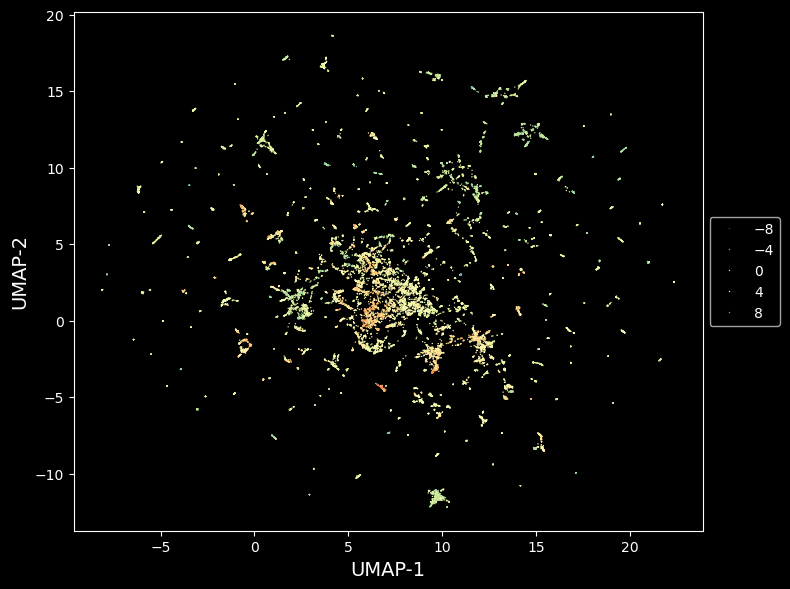

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap_black(df, color_column, cmap="Spectral", point_size=1, figsize=(8, 6)):
    plt.style.use("dark_background")
    
    plt.figure(figsize=figsize)
    scatter = sns.scatterplot(
        data=df,
        x="UMAP-1",
        y="UMAP-2",
        hue=color_column,
        palette=cmap,
        s=point_size,
        edgecolor=None,
        linewidth=0,
        alpha=1
    )

    plt.xlabel("UMAP-1", fontsize=14)
    plt.ylabel("UMAP-2", fontsize=14)
    scatter.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

plot_umap_black(df_final, color_column="cLogP", point_size=1)

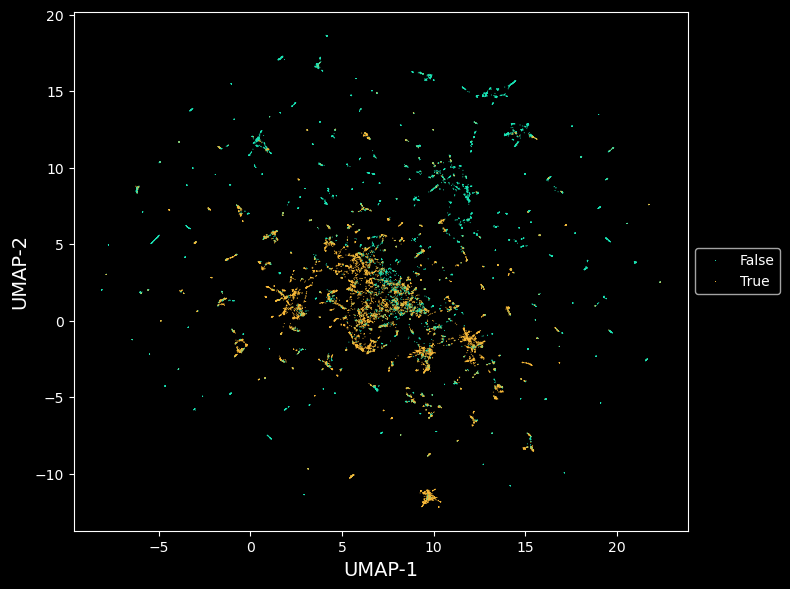

In [8]:
plot_umap_black(df_final, color_column="AUG", point_size=.5, cmap='turbo')

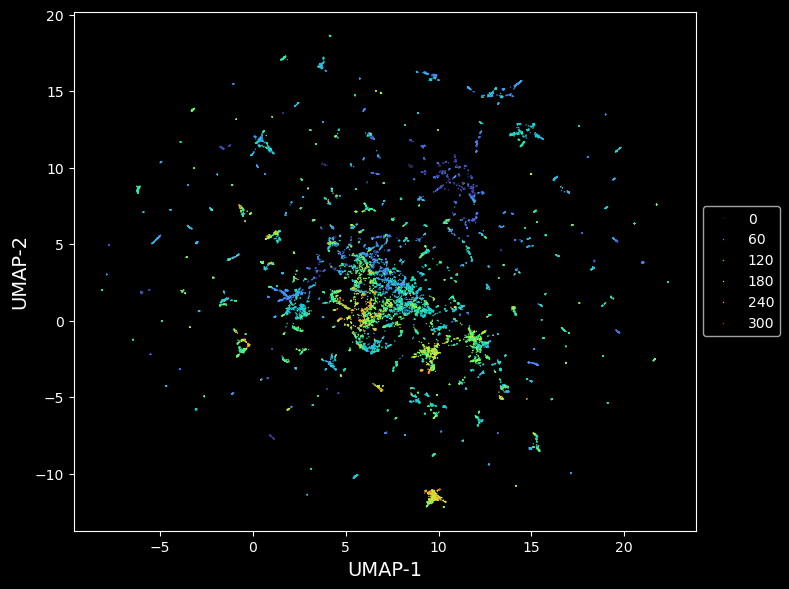

In [9]:
plot_umap_black(df_final, color_column="TPSA", point_size=1, cmap='turbo')

In [10]:
df_final

,InChIKey,SMILES,AUG,oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN),oneADMET_LR-STL---pK$_{i}$ CXCR3 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ AMPN (HUMAN),oneADMET_LR-STL---pIC$_{50}$ ANM6 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ MP2K1 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ CAH12 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ SC6A2 (HUMAN),...,oneADMET_LR-STL---pIC$_{50}$ CCR6 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ KPCA (HUMAN),oneADMET_LR-STL---pIC$_{50}$ ACHA3 (HUMAN),oneADMET_LR-STL---pIC$_{50}$ EDNRB (PIG),oneADMET_LR-STL---pK$_{i}$ CAH2 (HUMAN),MolWt,TPSA,cLogP,UMAP-1,UMAP-2
0,AAARPHXZKXDSID-UHFFFAOYSA-N,CCc1nc2c(-c3ccc(Cl)cc3Cl)ccnc2n1C(C)C1CC1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,360.288,30.71,5.93850,18.034294,10.708123
1,AACCYDBZWAOEIL-UHFFFAOYSA-N,Cc1cc(Oc2ncccc2OC(F)F)ccc1-c1c(C)n[nH]c(=O)c1C,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,373.359,77.10,4.15086,-5.133682,5.381115
2,AACFRCSOPDLTDR-UHFFFAOYSA-N,NS(=O)(=O)c1cc(-c2nnco2)c(Cl)cc1Br,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.803880,338.570,99.08,1.79990,12.923670,-2.862096
3,AACQDFGZWCHRFB-UHFFFAOYSA-N,NS(=O)(=O)c1cc(Cl)c(NC(=O)CN(CCN(CCN(CC(=O)O)C...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.218360,661.068,308.34,-3.18230,6.564637,0.311632
4,AAEKYDZGGXPAQR-UHFFFAOYSA-N,CC(CC(=O)O)C(=O)Nc1nnc(S(N)(=O)=O)s1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.045088,294.314,152.34,-0.76520,9.611689,-3.140912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22566,ZZVSKGLCVXEUBB-UHFFFAOYSA-N,NS(=O)(=O)c1ccc(-n2cc(Cn3cc(F)c(=O)[nH]c3=O)nn...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.173925,366.334,145.73,-1.04790,8.900022,-4.689110
22567,ZZVYFDKYNUQAJO-UHFFFAOYSA-N,NS(=O)(=O)c1ccc(NN=C2C(=O)N(Br)c3ccc(Br)cc32)cc1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.778403,474.134,104.86,2.56920,-1.624247,1.336191
22568,ZZWUAVHTSLQEHR-UHFFFAOYSA-N,CC(C)(C)c1ccc2c(c1)C(=O)N(C(=O)N1CCN(C(=O)c3cc...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.581237,498.561,138.16,1.80550,12.105515,-1.896076
22569,ZZWUEOYQVWAKCJ-UHFFFAOYSA-N,CC(NC1CCCC1)C(=O)c1cccc(Br)c1,False,NaN,NaN,NaN,NaN,NaN,NaN,4.596879,...,NaN,NaN,NaN,NaN,NaN,296.208,29.10,3.55250,-1.571160,11.256754


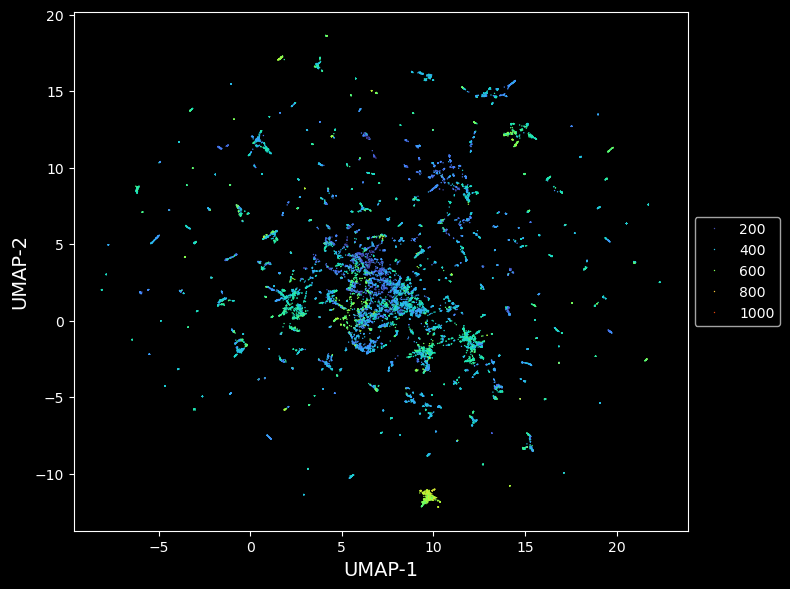

In [11]:
plot_umap_black(df_final, color_column="MolWt", point_size=1, cmap='turbo')

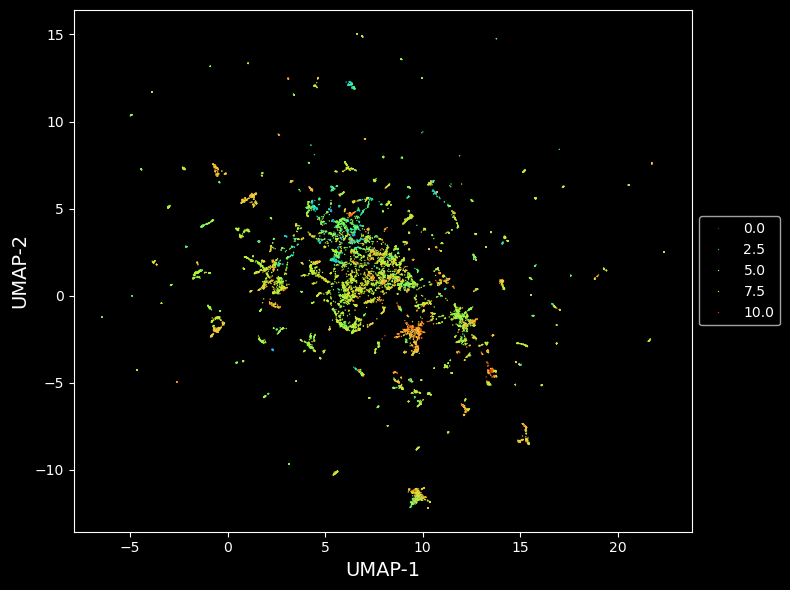

In [12]:
plot_umap_black(df_final, color_column="oneADMET_LR-STL---pK$_{i}$ CAH2 (HUMAN)", point_size=1, cmap='turbo')